In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tensorflow as tf
import random
import cv2

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
pwd = os.getcwd()

In [3]:
pwd

'/Users/arpit/Documents/Face_Mask_Detection'

In [4]:
print(os.listdir('/Users/arpit/Documents/Face_Mask_Detection/data/Train'))
print(os.listdir('/Users/arpit/Documents/Face_Mask_Detection/data/Test'))
print(os.listdir('/Users/arpit/Documents/Face_Mask_Detection/data/Validation'))

['.DS_Store', 'WithoutMask', 'WithMask']
['.DS_Store', 'WithoutMask', 'WithMask']
['.DS_Store', 'WithoutMask', 'WithMask']


In [5]:
# Number of training images is the dataset
print("Mask images count: ",len(os.listdir('/Users/arpit/Documents/Face_Mask_Detection/data/Train/WithMask')))
print("Non-Mask images count: ",len(os.listdir('/Users/arpit/Documents/Face_Mask_Detection/data/Train/WithoutMask')))

Mask images count:  5000
Non-Mask images count:  5000


In [6]:
train_dir = "/Users/arpit/Documents/Face_Mask_Detection/data/Train/"
val_dir = "/Users/arpit/Documents/Face_Mask_Detection/data/Validation/"
test_dir = "/Users/arpit/Documents/Face_Mask_Detection/data/Test/"

# Update Config For Transfer Learning

In [7]:
HEIGHT = 150
WEIGHT = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, # Normalization 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
# loading the data 
training_generator = train_datagen.flow_from_directory(directory=train_dir,
                                          target_size=(HEIGHT,WEIGHT),
                                          class_mode="categorical",
                                          batch_size=64
                                          )

validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                            target_size=(HEIGHT,WEIGHT),
                                            class_mode="categorical",
                                            batch_size=64)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                            target_size=(HEIGHT,WEIGHT),
                                            class_mode="categorical",
                                            batch_size=64)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150, 150, 3), alpha=1.0)


Metal device set to: Apple M1


2022-02-17 15:22:41.274605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-17 15:22:41.274832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [2]:
# Frezing the last layer
for layer in mobilenet.layers:
    layer.trainable = False

In [4]:
mobilenet.summary()
# Now trainable parameters are zero

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [31]:
# adding layers to the bottom of the mobilenet model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,GlobalAveragePooling2D,Dropout

model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(300, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               384300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)              

In [54]:
# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",metrics ="accuracy")

In [55]:
# fiting the model
history = model.fit(training_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=len(train)//64,
                              epochs=50,
                              validation_steps=len(val)//64,
                              verbose=2)

Epoch 1/50


2022-02-17 15:11:29.265605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 - 2s - loss: 0.1484 - accuracy: 0.9766
Epoch 2/50
2/2 - 1s - loss: 0.2973 - accuracy: 0.9453
Epoch 3/50
2/2 - 1s - loss: 0.1840 - accuracy: 0.9609
Epoch 4/50
2/2 - 1s - loss: 0.0892 - accuracy: 0.9609
Epoch 5/50
2/2 - 1s - loss: 0.4110 - accuracy: 0.9375
Epoch 6/50
2/2 - 1s - loss: 0.0921 - accuracy: 0.9766
Epoch 7/50
2/2 - 1s - loss: 0.1796 - accuracy: 0.9375
Epoch 8/50
2/2 - 1s - loss: 0.0775 - accuracy: 0.9766
Epoch 9/50
2/2 - 1s - loss: 0.1081 - accuracy: 0.9688
Epoch 10/50
2/2 - 1s - loss: 0.1240 - accuracy: 0.9609
Epoch 11/50
2/2 - 1s - loss: 0.0747 - accuracy: 0.9766
Epoch 12/50
2/2 - 1s - loss: 0.0967 - accuracy: 0.9609
Epoch 13/50
2/2 - 1s - loss: 0.1911 - accuracy: 0.9609
Epoch 14/50
2/2 - 1s - loss: 0.2555 - accuracy: 0.9453
Epoch 15/50
2/2 - 1s - loss: 0.0384 - accuracy: 0.9922
Epoch 16/50
2/2 - 1s - loss: 0.1459 - accuracy: 0.9453
Epoch 17/50
2/2 - 1s - loss: 0.0874 - accuracy: 0.9688
Epoch 18/50
2/2 - 1s - loss: 0.1141 - accuracy: 0.9688
Epoch 19/50
2/2 - 1s - loss: 0

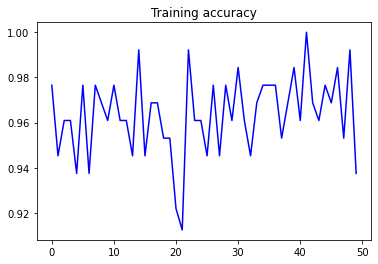

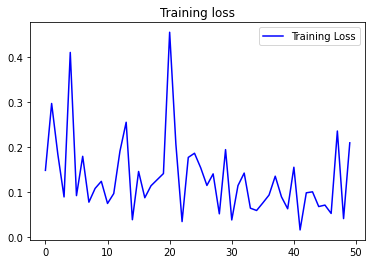

In [56]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [57]:
model.evaluate(val)

2022-02-17 15:13:16.768189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 3s 196ms/step - loss: 0.0425 - accuracy: 0.9862


[0.04252183809876442, 0.9862499833106995]

In [18]:
model.save('mobilenet.h5')

/Users/arpit/miniforge3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [26]:
model = tf.keras.models.load_model("mobilenet.h5")

In [27]:
import numpy as np
import cv2
import random

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
mouth_cascade = cv2.CascadeClassifier('Mouth.xml')

bw_threshold = 80

font = cv2.FONT_HERSHEY_SIMPLEX
org = (30, 30)
weared_mask_font_color = (0, 255, 0)
not_weared_mask_font_color = (0, 0, 255)
noface = (255, 255, 255)
thickness = 2
font_scale = 1
weared_mask = "Thank You for wearing MASK"
not_weared_mask = "Please wear MASK"

cap = cv2.VideoCapture(0)

while True:
    ret, img = cap.read()
    img = cv2.flip(img,1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, black_and_white) = cv2.threshold(gray, bw_threshold, 255, cv2.THRESH_BINARY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    faces_bw = face_cascade.detectMultiScale(black_and_white, 1.1, 4)
    if(len(faces) == 0 and len(faces_bw) == 0):
        cv2.putText(img, "No face found...", org, font, font_scale, noface, thickness, cv2.LINE_AA)
    elif(len(faces) == 0 and len(faces_bw) == 1):
        cv2.putText(img, weared_mask, org, font, font_scale, weared_mask_font_color, thickness, cv2.LINE_AA)
    else:
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)
            roi_gray = gray[y:y + h, x:x + w]
            roi_color = img[y:y + h, x:x + w]
            mouth_rects = mouth_cascade.detectMultiScale(gray, 1.5, 5)
        if(len(mouth_rects) == 0):
            cv2.putText(img, weared_mask, org, font, font_scale, weared_mask_font_color, thickness, cv2.LINE_AA)
        else:
            for (mx, my, mw, mh) in mouth_rects:
                if(y < my < y + h):
                    cv2.putText(img, not_weared_mask, org, font, font_scale, not_weared_mask_font_color, thickness, cv2.LINE_AA)
                    break
    cv2.imshow('Mask Detection', img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 